In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
plt.style.use('ggplot')
seaborn.set_context('talk')

In [25]:
data=(pd.read_csv('the-price-for-lighting-per-million-lumen-hours-in-the-uk-in-british-pound.csv').set_index('Year')
      .rolling(50,win_type='triang',center=True,min_periods=0).mean()
     )
data

,PoL
Year,
1301,35733.489232
1302,35635.897774
1303,35544.322788
1304,35435.212820
1305,35307.159271
1306,35158.873624
1307,34995.868324
1308,34826.873175
1309,34658.461145


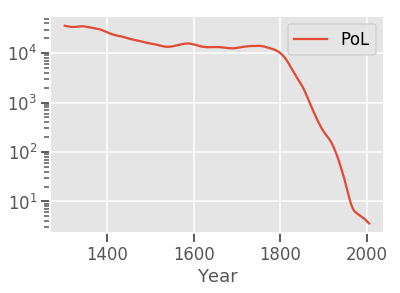

In [26]:
data.plot()
plt.yscale('log')

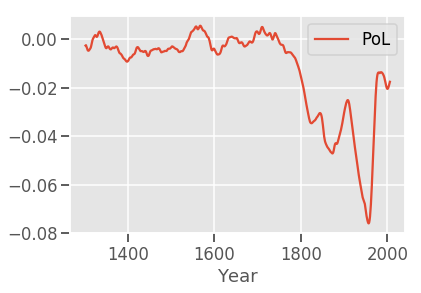

In [27]:
data.pct_change().plot()

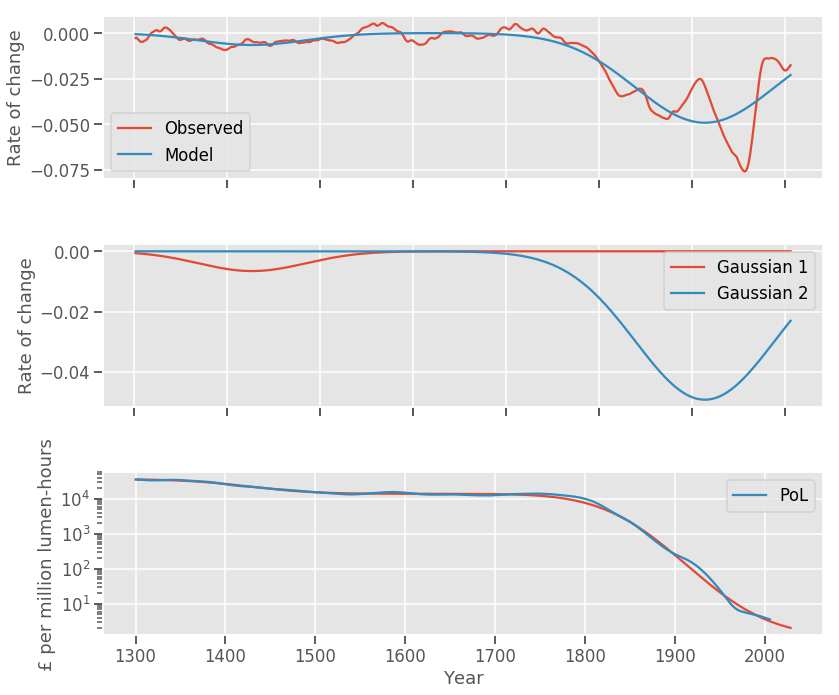

In [56]:
t=data.copy()
def gauss(x, A, mu, sigma):

    return A*np.exp(-(x - mu) ** 2 / 2 / sigma ** 2)


def bimodal(x, mu1, mu2, A1, A2, sigma1, sigma2):

    return gauss(x, A1, mu1, sigma1) + gauss(x, A2, mu2, sigma2) + 0


from scipy.optimize import curve_fit

this = t.reset_index(drop=True).pct_change().dropna().copy()

to_fit = this.copy()
to_fit.index=to_fit.index.astype(float)


FUNCTION=bimodal
coef, _ = curve_fit(
    bimodal,
    to_fit.index.values.squeeze(),
    to_fit.values.squeeze(),
    maxfev=10000000,
    p0=[1500-1300,1900-1300,-1,-1,1,1],
    bounds=[(0,0,-100,-100,0,0),(1000,1000,0,0,1000,1000)],
)


plt.figure(figsize=(12, 10))
ax = plt.subplot(3, 1, 1)
this.index = t.index[1:]
this.plot(ax=plt.gca())
k = pd.DataFrame({"Model": FUNCTION(to_fit.index, *coef)}).set_index(t.index[1:])
k.plot(ax=plt.gca())

plt.legend(["Observed", "Model"])
plt.ylabel("Rate of change")
plt.subplot(3, 1, 2, sharex=ax)
k = pd.DataFrame(
    {
        "Gaussian 1": gauss(to_fit.index, coef[2], coef[0], coef[4]),
        "Gaussian 2": gauss(to_fit.index, coef[3], coef[1], coef[5]),
    }
   #{"Gaussian 1": FUNCTION(to_fit.index, *coef)}
).set_index(t.index[1:])
k.plot(ax=plt.gca())
plt.ylabel("Rate of change")


plt.subplot(3, 1, 3)
tmax=np.arange(1300,2030).astype(float)

plt.plot(tmax,np.cumprod((FUNCTION(tmax-t.index[0], *coef)+1))*t.iloc[0,0])
t.pipe(lambda x: x).plot(ax=plt.gca())
plt.yscale('log')
plt.ylabel("£ per million lumen-hours")

plt.tight_layout()
plt.savefig('sumgaus_mlight.png')

/home/jose/envs/env/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.18433881]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 94, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


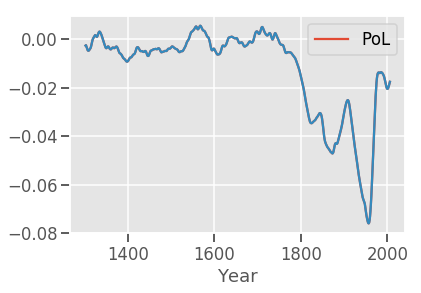

In [55]:
d=t.pct_change().dropna()
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
gp=GaussianProcessRegressor(kernel=RBF())
gp.fit(d.index.values.reshape(-1,1),d.values)
d.plot()
plt.plot(d.index,gp.predict(d.index.values.reshape(-1,1)).squeeze())

In [53]:
gp

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)